# Import Required Libraries

In [1]:
import os
import glob
from IPython.display import Image as IPImage
import pandas as pd             # Pandas
import numpy as np              # NumPy
import matplotlib.pyplot as plt # Matplotlib
import seaborn as sns           # Seaborn
from PIL import Image           # Pillow

# TensorFlow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model

# Keras
from keras.layers import Flatten, Dense, Activation, Dropout
from keras import models, optimizers
from keras.models import Sequential
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, Adamax
#from keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json
from keras.regularizers import l2
from keras.layers import Conv2D, MaxPooling2D
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications import DenseNet121
from keras.applications.densenet import DenseNet121, preprocess_input

# scikit-learn
from sklearn.model_selection import train_test_split

                                                Path      Label
0  E:\\my graduation project\\archive (2)\\Datase...  malignant
1  E:\\my graduation project\\archive (2)\\Datase...     benign
2  E:\\my graduation project\\archive (2)\\Datase...     benign
3  E:\\my graduation project\\archive (2)\\Datase...     normal
4  E:\\my graduation project\\archive (2)\\Datase...     benign


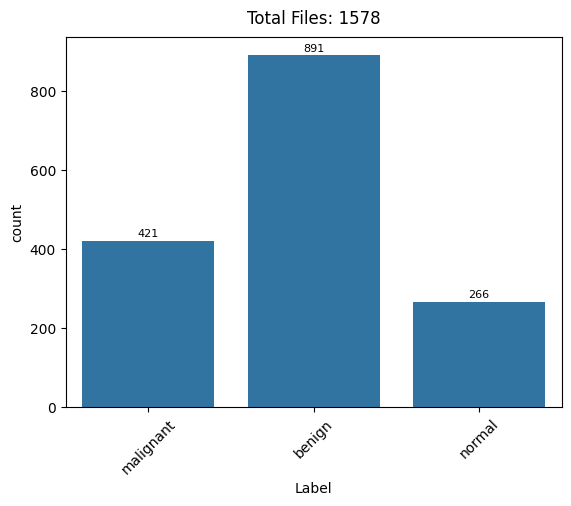

In [2]:


# Define the path to the directory containing the images for training
dataset_path = r"E:\\my graduation project\\archive (2)\\Dataset_BUSI_with_GT"

# Create a Pandas DataFrame with a single column
# The column is populated with the list of file/directory names in the 'dataset_path' directory
df = pd.DataFrame(
    os.listdir(dataset_path),
    columns=['File Name']
)

# Get a list of the file paths in the 'dataset_path' directory
train_files = [i for i in glob.glob(dataset_path + "\\*\\*")]

# Randomly shuffle the list of file paths
np.random.shuffle(train_files)

# Extract labels from the directory names of each file path
labels = [os.path.dirname(i).split("\\")[-1] for i in train_files]

# Combine file paths & their corresponding labels into a list of tuples
data = zip(train_files, labels)

# Create a Pandas DataFrame with 2 columns
# "Path" column contains file paths, & "Label" column contains corresponding labels
training_data = pd.DataFrame(data, columns=["Path", "Label"])

# Display the contents of the DataFrame
print(training_data.head())

# Create a countplot() using Seaborn, where x-axis represents the "Label" column of the training_data DataFrame
ax = sns.countplot(x=training_data["Label"])

# Display count inside each bar as integers
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=8)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Add a title with the total count of files
plt.title(f'Total Files: {len(training_data)}', pad=10)

# Show the plot
plt.show()


In [3]:
data_paths = []
labels = []

main_dirs = os.listdir(dataset_path)
for folder_name in main_dirs:
    folder_path = os.path.join(dataset_path, folder_name)
    files = os.listdir(folder_path)
    for file in files:
        file_path = os.path.join(folder_path, file)
        data_paths.append(file_path)
        labels.append(folder_name)



In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Set the batch size for training
batch_size = 16

# Define the target image size for preprocessing
image_size = (128,128)

# Specify the number of color channels in the images (3 for RGB)
num_channels = 3

# Create the image shape tuple based on the specified size and channels
image_shape = (image_size[0], image_size[1], num_channels)

# Create a Pandas Series containing file paths with the name 'Path'
data_dirs = pd.Series(data_paths, name='Path')

# Create a Pandas Series containing corresponding labels with the name 'Label'
classes = pd.Series(labels, name='Label')

def preprocess_image(img):
    return img

# Split the data into training and validation-test sets
train_df, val_test_df = train_test_split(
    training_data, 
    train_size=0.8, 
    shuffle=True, 
    random_state=123
)

# Further split the validation-test set into validation and test sets
val_df, test_df = train_test_split(
    val_test_df, 
    train_size=0.5, 
    shuffle=True, 
    random_state=123
)

# ImageDataGenerator configuration
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image, 
    rescale=1.0/255
)

# Convert the 'Label' column to string type
train_df['Label'] = train_df['Label'].astype(str)
val_df['Label'] = val_df['Label'].astype(str)

# Create generators for training, validation, and testing
train_generator = datagen.flow_from_dataframe(
    train_df, 
    x_col='Path', 
    y_col='Label',
    target_size=image_size, 
    class_mode='categorical',
    color_mode='rgb', 
    shuffle=True, 
    batch_size=batch_size
)

valid_generator = datagen.flow_from_dataframe(
    val_df, 
    x_col='Path', 
    y_col='Label',
    target_size=image_size, 
    class_mode='categorical',
    color_mode='rgb', 
    shuffle=True, 
    batch_size=batch_size
)

Found 1262 validated image filenames belonging to 3 classes.
Found 158 validated image filenames belonging to 3 classes.


In [5]:
# Get the class indices (mapping of the class names to numerical indices) from the training generator
class_indices = train_generator.class_indices

# Display the keys (class names) from the class_indices dictionary
class_indices.keys()

dict_keys(['benign', 'malignant', 'normal'])

In [6]:
# Initialize an empty list to store class labels
labels = []

# Iterate through the keys (class names) in the class_indices dictionary
for key in class_indices.keys():
    labels.append(key)  # Append each class name to the labels list

# Calculate the total no. of unique labels
total_labels = len(labels)

# Print the list of class labels and the total no. of unique labels
print("Labels: ", labels)
print("\nTotal no. of unique labels:", total_labels)

Labels:  ['benign', 'malignant', 'normal']

Total no. of unique labels: 3


(598, 449, 3)
(471, 558)
(583, 770)
(587, 777, 3)
(471, 562)
(578, 772, 3)
(328, 500)
(396, 469)


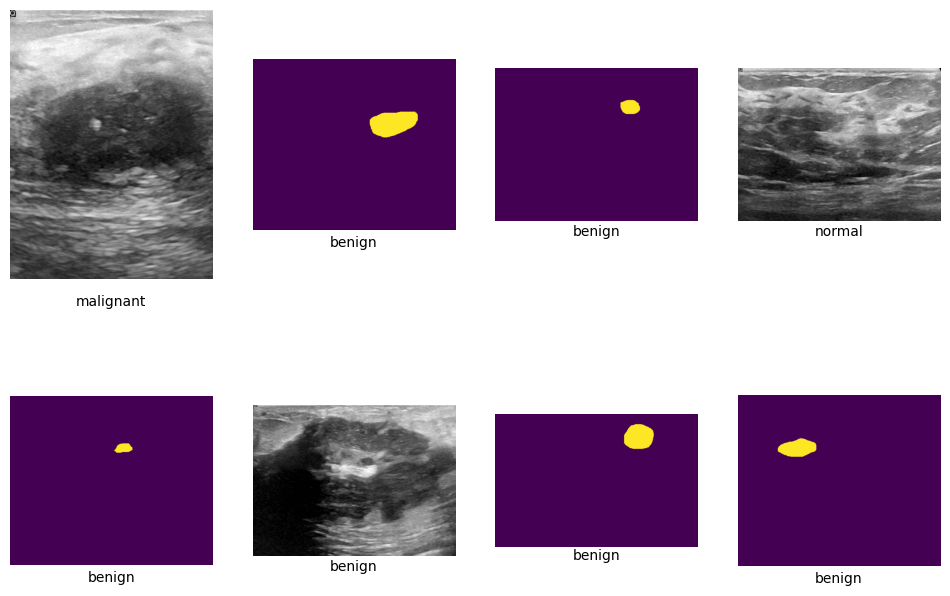

In [7]:
# Set the number of rows and columns for the subplot grid
no_of_rows = 2
no_of_columns = 4

# Create a subplot grid with the specified number of rows and columns
fig, axes = plt.subplots(no_of_rows, no_of_columns, figsize=(12, 8))

# Iterate through the rows
for i in range(no_of_rows):
    # Iterate through the columns
    for j in range(no_of_columns):
        # Calculate the index for accessing the data
        index = i * no_of_columns + j

        # Check if the index is within the bounds of the data
        if index < len(training_data):

            # Open the image using the PIL library
            im = Image.open(training_data.iloc[index]['Path'])

            # Convert the PIL image to a NumPy array
            img = np.array(im)

            # Print the shape of the image array
            print(img.shape)

            # Display the image on the subplot at position (i, j)
            axes[i, j].imshow(img)

            # Turn off axis labels for better visualization
            axes[i, j].axis('off')

            # Get the label for the current image and display it as text
            label = training_data.iloc[index]['Label']
            axes[i, j].text(0.5, -0.1, label, ha='center', transform=axes[i, j].transAxes)

# Show the entire subplot grid
plt.show()

# Build the model

In [8]:
base_model = DenseNet121(
    weights="imagenet",  #  Use ImageNet pretrained weights
    include_top=False, 
    input_shape=(128, 128, 3)
)

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create model
model = Sequential()

# Add the pre-trained DenseNet-121 base model
model.add(base_model)

# Flatten the output of the base model
model.add(Flatten())

# Add fully connected layers with dropout for regularization
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))

# Additional layers for classification
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Display the summary of the model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 4, 4, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      16,778,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,456,195 (97.11 MB)

 Trainable params: 18,418,691 (70.26 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

**Create Model Checkpoint Callback to Save Best Model**

In [9]:
# ✅ Compile the model before training
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Define the path to save the best model checkpoint
checkpoint_path = r"E:\my graduation project\django_form\notebook\BreastCancer.h5"

# Create a ModelCheckpoint callback
# This callback saves the model when validation accuracy improves
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  # Monitor validation accuracy
    save_best_only=True,     # Save only the best model
    mode='max',              # Save based on the maximum validation accuracy
    verbose=1                # Display progress information
)                

# Compile Model

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint


checkpoint = ModelCheckpoint(
    "BreastCancer.keras",   #  Save in `.keras` format
    monitor="val_loss", 
    save_best_only=True, 
    mode="min"
)

#  Continue training for 10 more epochs
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=valid_generator,
    callbacks=[checkpoint]
)



C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 56s 532ms/step - accuracy: 0.6495 - loss: 0.8292 - val_accuracy: 0.8418 - val_loss: 0.3940
Epoch 2/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 452ms/step - accuracy: 0.7704 - loss: 0.5226 - val_accuracy: 0.7722 - val_loss: 0.4449
Epoch 3/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 38s 486ms/step - accuracy: 0.8229 - loss: 0.4343 - val_accuracy: 0.9051 - val_loss: 0.2753
Epoch 4/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 35s 446ms/step - accuracy: 0.8443 - loss: 0.3755 - val_accuracy: 0.8924 - val_loss: 0.2914
Epoch 5/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 32s 408ms/step - accuracy: 0.8760 - loss: 0.3037 - val_accuracy: 0.8987 - val_loss: 0.2753
Epoch 6/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 31s 395ms/step - accuracy: 0.8917 - loss: 0.2720 - val_accuracy: 0.8481 - val_loss: 0.2996
Epoch 7/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 31s 389ms/step - accuracy: 0.8936 - loss: 0.2539 - val_accuracy: 0.8861 - val_loss: 0.2851
Epoch 8/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 33s 413ms/step - accuracy: 0.8867 - loss: 0.2766 - val_accu

In [11]:

# Load the previous best model 
checkpoint_path = r"E:\my graduation project\django_form\notebook\BreastCancer.h5"

# Compile the model before training
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Define ModelCheckpoint to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor="val_accuracy",   # Monitor validation accuracy
    save_best_only=True,      # Save only the best model
    mode="max",               # Save based on the highest validation accuracy
    verbose=1                 # Display progress information
)

#  Continue training for 10 more epochs
history = model.fit(
    train_generator,
    epochs=5,  # Add 5 more epochs
    validation_data=valid_generator,
    callbacks=[checkpoint]
)

print("Training complete! The best model is saved at:", checkpoint_path)


Epoch 1/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.9590 - loss: 0.1099 
Epoch 1: val_accuracy improved from -inf to 0.84810, saving model to E:\my graduation project\django_form\notebook\BreastCancer.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 53s 506ms/step - accuracy: 0.9589 - loss: 0.1101 - val_accuracy: 0.8481 - val_loss: 0.4927
Epoch 2/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.9536 - loss: 0.1454 
Epoch 2: val_accuracy improved from 0.84810 to 0.90506, saving model to E:\my graduation project\django_form\notebook\BreastCancer.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 453ms/step - accuracy: 0.9538 - loss: 0.1450 - val_accuracy: 0.9051 - val_loss: 0.2928
Epoch 3/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.9690 - loss: 0.1101 
Epoch 3: val_accuracy improved from 0.90506 to 0.93671, saving model to E:\my graduation project\django_form\notebook\BreastCancer.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 35s 447ms/step - accuracy: 0.9690 - loss: 0.1100 - val_accuracy: 0.9367 - val_loss: 0.2707
Epoch 4/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.9793 - loss: 0.0660 
Epoch 4: val_accuracy did not improve from 0.93671
79/79 ━━━━━━━━━━━━━━━━━━━━ 35s 445ms/step - accuracy: 0.9792 - loss: 0.0662 - val_accuracy: 0.9304 - val_loss: 0.2947
Epoch 5/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.9813 - loss: 0.0585 
Epoch 5: val_accuracy did not improve from 0.93671
79/79 ━━━━━━━━━━━━━━━━━━━━ 37s 468ms/step - accuracy: 0.9812 - loss: 0.0586 - val_accuracy: 0.9304 - val_loss: 0.3315
Training complete! The best model is saved at: E:\my graduation project\django_form\notebook\BreastCancer.h5


In [12]:
# Evaluate the model on the train set
train_loss, train_accuracy = model.evaluate(train_generator, steps=train_generator.samples // train_generator.batch_size)

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(valid_generator, steps=valid_generator.samples // valid_generator.batch_size)

# Convert accuracy to percentage
train_accuracy_percentage = train_accuracy * 100
val_accuracy_percentage = val_accuracy * 100

# Create a Pandas DataFrame to display the results
evaluation_results = pd.DataFrame({
    'Set': ['Train', 'Validation'],
    'Loss': [train_loss, val_loss],
    'Accuracy': [f'{train_accuracy_percentage:.2f}%', f'{val_accuracy_percentage:.2f}%']
})

# Display the evaluation results DataFrame
evaluation_results

78/78 ━━━━━━━━━━━━━━━━━━━━ 24s 302ms/step - accuracy: 0.9941 - loss: 0.0206
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 279ms/step - accuracy: 0.9206 - loss: 0.3500


,Set,Loss,Accuracy
0,Train,0.017857,99.44%
1,Validation,0.347570,93.06%


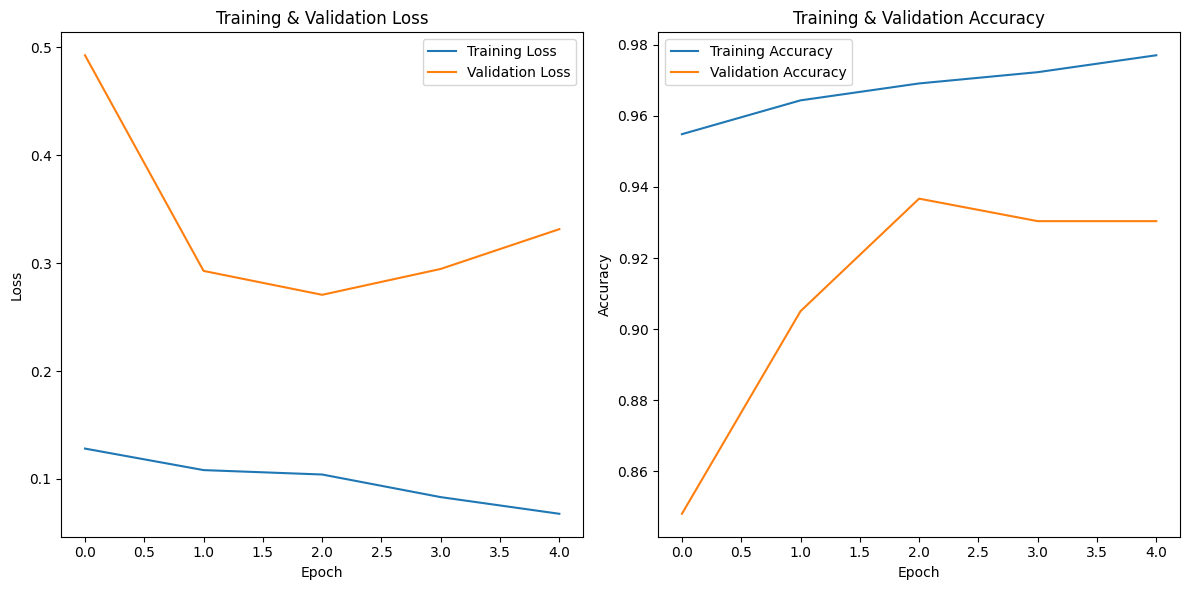

In [13]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')  #  Corrected
plt.plot(history.history['val_loss'], label='Validation Loss')  #  Corrected
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')  #  Corrected
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  #  Corrected
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()
